Original code from https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py under the following license:

MIT License

Copyright (c) 2017 Erik Linder-Norén

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The author's model was based on the paper here: https://arxiv.org/pdf/1511.06434.pdf

## Setup

If you haven't already, please follow the [setup instructions](https://jennselby.github.io/MachineLearningCourseNotes/#setup-and-tools) to get all of the necessary software (Github is optional).

1. Install h5, with `python3 -m pip install h5py`
1. Download the three h5 files: [generator](https://github.com/jennselby/MachineLearningTutorials/raw/master/generator.h5), [discriminator](https://github.com/jennselby/MachineLearningTutorials/raw/master/discriminator.h5), and [combined](https://github.com/jennselby/MachineLearningTutorials/raw/master/combined.h5) and save them in the same folder as this file.

In [1]:
%matplotlib inline

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from IPython.display import Image

import sys

import numpy as np

In [4]:
# Global Constants
images_dir = "dcgan_images"
img_rows = 28 
img_cols = 28
channels = 1
noise_len = 100

## Define functions for creating, training, and using the models

In [5]:
def build_discriminator():
    '''
    Put together a CNN that will return a single confidence output.
    
    returns: the model object
    '''

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def build_generator():
    '''
    Put together a model that takes in one-dimensional noise and outputs two-dimensional
    data representing a black and white image, with -1 for black and 1 for white.
    
    returns: the model object
    '''

    noise_shape = (noise_len,)

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

def build_combined():
    '''
    Puts together a model that combines the discriminator and generator models.
    
    returns: the generator, discriminator, and combined model objects
    '''
    
    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])


    # Build and compile the generator
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # The generator takes noise as input and generates images
    noise = Input(shape=(noise_len,))
    img = generator(noise)
    
    # For the combined model we will only train the generator
    discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity 
    combined = Model(inputs=noise, outputs=valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator, discriminator, combined

def save_imgs(generator, iteration):
    '''
    Has the generator create images and saves the images in a single file that includes
    the number of iterations in the filename.
    
    inputs:
        generator: the generator model object returned by build_combined
        iteration: the iteration number (but can be anything that can be represented as a string)
    
    returns: None
    '''
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_len))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    #fig.suptitle("DCGAN: Generated digits", fontsize=12)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(images_dir, 'mnist_{}.png'.format(iteration)))
    plt.close()

def train(generator, discriminator, combined, iterations, batch_size=128, save_interval=50):
    '''
    Trains all model objects
    
    generator: the generator model object returned by build_combined
    discriminator: the discriminator model object returned by build_combined
    combined: the combined model object returned by build_combined
    iterations: integer, the number of iterations to train for
    batch_size: integer, the number of training samples to use at a time
    save_interval: integer, will generate and save images when the current iteration_num % save_interval is 0
    
    returns: None
    '''

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for iteration in range(iterations):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Sample noise and generate a half batch of new images
        noise = np.random.normal(0, 1, (half_batch, noise_len))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_len))

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        # If at save interval => save generated image samples and plot progress
        if iteration % save_interval == 0:
            # Plot the progress
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            print ("{} [D loss: {}, acc.: {:.2%}] [G loss: {}]".format(iteration, d_loss[0], d_loss[1], g_loss))
            save_imgs(generator, iteration)
            
def show_new_image(generator):
    '''
    Generates and displays a new image
    
    inputs: generator object model returned from build_combined
    
    returns: generated image
    '''
    
    noise = np.random.normal(0, 1, (1, noise_len))
    gen_img = generator.predict(noise)[0][:,:,0]
    
    return plt.imshow(gen_img, cmap='gray', vmin=-1, vmax=1)

## This is the main section of the code, that actually creates the model objects

With the parameters below, the model training took almost 14 hours on my laptop.

In [6]:
# set up directories to hold the images that are saved during training checkpoints.
import os

if (not os.path.isdir(images_dir)):
    os.mkdir(images_dir)

In [7]:
generator, discriminator, combined = build_combined()

We can take a look at what each of the models look like.

In [7]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)      

In [8]:
# Note that we get a warning here about weights being trainable.
# When we are training the discriminator, we want its weights to be trainable.
# When we are training the generator, we want the discriminator weights to be fixed.
# This is surprising to Keras, so it is warning us to check that this is really what we want (it is!)
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0

In [9]:
combined.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         856705    
_________________________________________________________________
sequential (Sequential)      (None, 1)                 392705    
Total params: 1,249,410
Trainable params: 856,065
Non-trainable params: 393,345
_________________________________________________________________


## Training the model
Note that because we are doing something unusual -- having the discriminator weights sometimes train and sometimes stay fixed -- we get a warning about trainable weights.

In [10]:
# Uncomment if you want to train your model (it took almost 14 hours on my laptop)
# Lower the number of iterations when you start debugging! You want a short testing cycle until you are confident
# that the code is working. Also, since the exercises involve models with less complicated patterns, you will
# likely not need as many iterations to train well.
#train(generator, discriminator, combined, iterations=4001, batch_size=32, save_interval=50)

If you do train a new model, then you can look at the saved files to see what the model output looks like after a certain number of iterations:

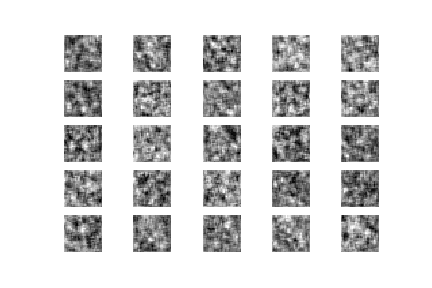

In [11]:
#Image(filename=os.path.join(images_dir, 'mnist_0.png'))

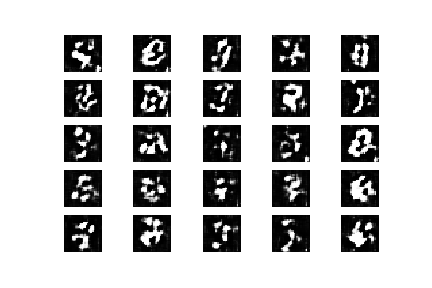

In [12]:
#Image(filename=os.path.join(images_dir, 'mnist_500.png'))

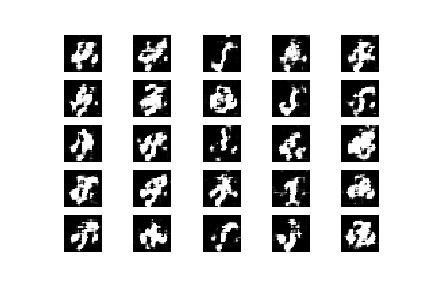

In [13]:
#Image(filename=os.path.join(images_dir, 'mnist_1000.png'))

In [14]:
# Uncomment to save your model files
#generator.save('generator.h5')
#discriminator.save('discriminator.h5')
#combined.save('combined.h5')

**Make sure that you have downloaded the three h5 files before running the next block.**

Download the three h5 files: [generator](https://github.com/jennselby/MachineLearningTutorials/raw/master/generator.h5), [discriminator](https://github.com/jennselby/MachineLearningTutorials/raw/master/discriminator.h5), and [combined](https://github.com/jennselby/MachineLearningTutorials/raw/master/combined.h5) and save them in the same folder as this file.

In [10]:
# Load the saved model files. Comment out (or don't run) this block if you want to start
# with fresh models.
from tensorflow.keras.models import load_model

generator = load_model('generator.h5')
discriminator = load_model('discriminator.h5')
combined = load_model('combined.h5')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Let's see how it worked, by having the model generate some images for us.

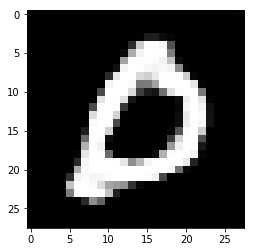

In [11]:
show_new_image(generator)

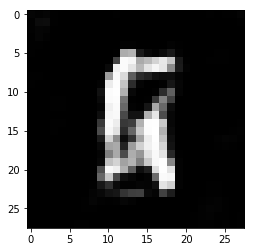

In [12]:
show_new_image(generator)

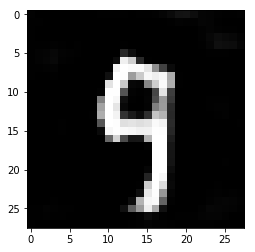

In [13]:
show_new_image(generator)

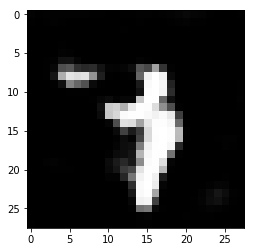

In [14]:
show_new_image(generator)

# Exercise Option 1
Change the model so that it learns to produce 9x9 images of some simple pattern, for instance horizontal lines.

# Exercise Option 2 (More Challenging)
Change the model so that you can select which number you get an image of rather than always getting a random one. I highly recommend that you limit your model to only learning two or three numbers, so that you can get decent results with less training time.